# HERE data

In [4]:
import os
import h5py
import numpy as np
from h5py import h5s
import torch

DATA_ROOT = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\hugging_face"


**The h5 format and fitting pytorch models**

"Hierarchical Data Format (HDF) is a set of file formats (HDF4, HDF5) designed to store and organize large amounts of data."(https://en.wikipedia.org/wiki/Hierarchical_Data_Format).


For pytorch we need **tensors**.

**Example of transformation of one file from h5 to numpy**

In [ ]:
example_data_path = os.path.join(DATA_ROOT, 'BERLIN_reduced, ''data', "2019-01-29_BERLIN_8ch.h5")

In [5]:
# FILE READING 
with h5py.File(example_data_path, "r") as f:
    dset = f["array"]
    did = dset.id

    # Get shape via low-level space object
    space = did.get_space()
    dims = space.get_simple_extent_dims()  # returns a tuple of dims
    shape = tuple(dims)
    print("Shape from file:", shape)

    # Allocate a normal float64 numpy array with that shape
    arr64 = np.empty(shape, dtype=np.float64)

    # Read from file into our float64 array
    # read(mspace, fspace, buf, mtype=None, dxpl=None)
    did.read(h5s.ALL, h5s.ALL, arr64)


Shape from file: (40, 128, 128, 8)


In [5]:
# Check nans
np.isnan(arr64).any()

np.False_

**Data transformations**
- Pytorch models expect (time_slots, chanels, height, width)
- We have a big amount of data so we need to consider memory. For that we cast the data to float32.
- We need tensors.


In [6]:
# Cast to float32
arr = arr64.astype(np.float32)

# Move channels last -> second axis: (T, H, W, C) -> (T, C, H, W)
arr = np.moveaxis(arr, -1, 1)

# Convert to torch tensor
X_torch = torch.tensor(arr, dtype=torch.float32)

# print(X_torch)
print(X_torch.shape)

torch.Size([288, 8, 495, 436])


Now let us think of **how to treat the data**

How much

- **Option 1: Save it as np** 

In [22]:

import os
import h5py
import numpy as np

# -------- CONFIG ---------
data_path_h5 = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\BERLIN_reduced\data"
sample_h5 = None
# -------------------------


# 1) Find one sample .h5 file
for root, _, files in os.walk(data_path_h5):
    for name in files:
        if name.lower().endswith(".h5"):
            sample_h5 = os.path.join(root, name)
            break
    if sample_h5:
        break

if sample_h5 is None:
    raise RuntimeError("No .h5 file found in the folder!")


print("Sample:", sample_h5)


# 2) Convert sample to .npy (temp file)
sample_npy = sample_h5 + ".temp.npy"

with h5py.File(sample_h5, "r") as f:
    arr = f["array"][()]

arr = arr.astype(np.float32)
np.save(sample_npy, arr)

# 3) Measure sizes
size_h5 = os.path.getsize(sample_h5) / 1e9
size_npy = os.path.getsize(sample_npy) / 1e9

print(f"Sample .h5 size : {size_h5:.3f} GB")
print(f"Sample .npy size: {size_npy:.3f} GB")

multiplier = size_npy / size_h5
print(f"Expansion factor: {multiplier:.2f}x")

# 4) Compute total size of all .h5
total_h5 = 0
num_files = 0

for root, _, files in os.walk(data_path_h5):
    for name in files:
        if name.lower().endswith(".h5"):
            num_files += 1
            total_h5 += os.path.getsize(os.path.join(root, name))

total_h5_gb = total_h5 / 1e9

print(f"\nTotal .h5 files: {num_files}")
print(f"Total .h5 size : {total_h5_gb:.3f} GB")

# 5) Estimated required space for all .npy
estimated_npy = total_h5_gb * multiplier
print(f"\nEstimated total .npy size: {estimated_npy:.2f} GB")

# Remove temporary file
os.remove(sample_npy)
print("\nTemporary sample .npy removed.")


Sample: C:\Users\user\UPM\Imperial-4año\IoT\Github\BERLIN_reduced\data\2019-01-02_BERLIN_8ch_reduced.h5
Sample .h5 size : 0.001 GB
Sample .npy size: 0.021 GB
Expansion factor: 21.04x

Total .h5 files: 180
Total .h5 size : 0.187 GB

Estimated total .npy size: 3.94 GB

Temporary sample .npy removed.


To much space.

- **Option 2: transform on the fly**
Best option for memory saving.

**Visualizing a data sample**

Best t: 195 with fraction>0: 0.11255676026318229


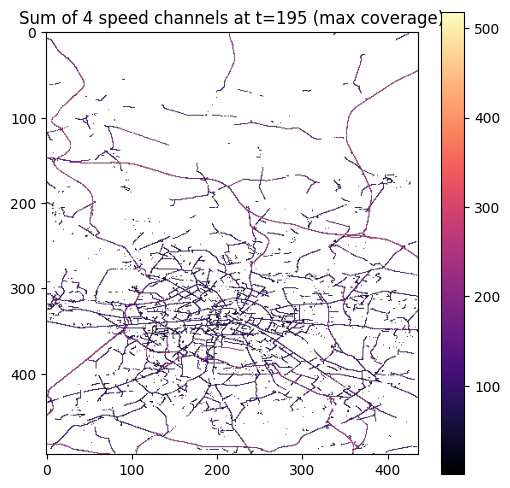

In [8]:
import numpy as np
import matplotlib.pyplot as plt
example_day = arr

# find the time slot with less 0's
fractions = []
for t in range(example_day.shape[0]):
    vols_speeds = example_day[t, :]
    sum_speed = vols_speeds.sum(axis=0)
    frac = (sum_speed > 0).mean()
    fractions.append(frac)

best_t = int(np.argmax(fractions))
print("Best t:", best_t, "with fraction>0:", fractions[best_t])

t = best_t

speeds_4 = X_torch[t, 4:8].cpu().numpy()
sum_speed = speeds_4.sum(axis=0)
sum_speed_masked = np.where(sum_speed > 0, sum_speed, np.nan)

plt.figure(figsize=(6, 6))
plt.title(f"Sum of 4 speed channels at t={t} (max coverage)")
plt.imshow(sum_speed_masked, cmap="magma")
plt.colorbar()
plt.show()



**visualizing a whole day**

In [9]:

# from IPython.display import clear_output
# import numpy as np
# import time

# T = X_torch.shape[0]

# plt.figure(figsize=(7,7))

# for t in range(T):
#     clear_output(wait=True)

#     # Combine all 4 speed channels at time t
#     speeds_4 = X_torch[t, 4:8].cpu().numpy()   # (4, H, W)
#     frame = speeds_4.sum(axis=0)               # (H, W)

#     # Mask zeros (no data)
#     frame = np.where(frame > 0, frame, np.nan)

#     plt.imshow(frame, cmap="magma", vmin=np.nanmin(frame), vmax=np.nanmax(frame))
#     plt.title(f"Sum of 4 speed channels — t={t} (15-min bins)")
#     plt.axis("off")
#     plt.colorbar()
#     plt.show()

#     time.sleep(0.1)  # speed of animation

KeyboardInterrupt: 

**bbox Berlin**

 13.189–13.625 / 52.359–52.854

In [10]:
import folium

def show_bbox(lat_min, lat_max, lon_min, lon_max, zoom=11):
    """
    Muestra un mapa folium con la bounding box sin guardarlo en archivo.
    """
    center_lat = (lat_min + lat_max) / 2
    center_lon = (lon_min + lon_max) / 2

    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color="red",
        weight=2,
        fill=False,
    ).add_to(m)

    return m


show_bbox(52.359, 52.854, 13.189, 13.625)



**We want to reduce it to only the center of Berlin**

**visualize the mask**

Static shape: (9, 128, 128)


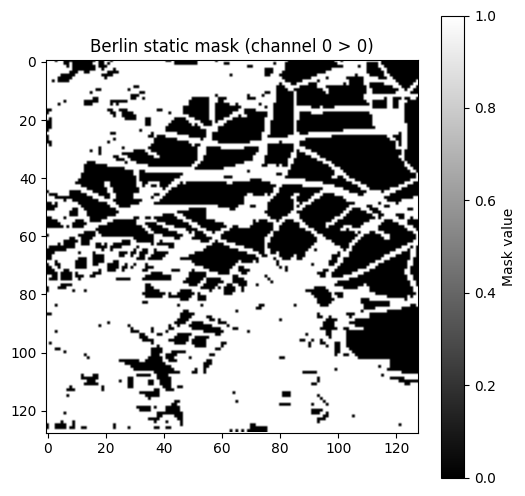

In [18]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

path = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\BERLIN\BERLIN\BERLIN_static.h5"
path = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\hugging_face\BERLIN_reduced\BERLIN_static.h5"

with h5py.File(path, "r") as f:
    static = f["array"][()]        # (C, H, W)

print("Static shape:", static.shape)

# mask is almost always channel 0
mask = static[0]                  # (H, W)

# convert to binary mask (0/1)
binary_mask = (mask > 0).astype(np.uint8)


plt.figure(figsize=(6, 6))
plt.title("Berlin static mask (channel 0 > 0)")
plt.imshow(binary_mask, cmap="gray")
plt.colorbar(label="Mask value")
plt.show()



**Range of the 4 channels acrross a day**

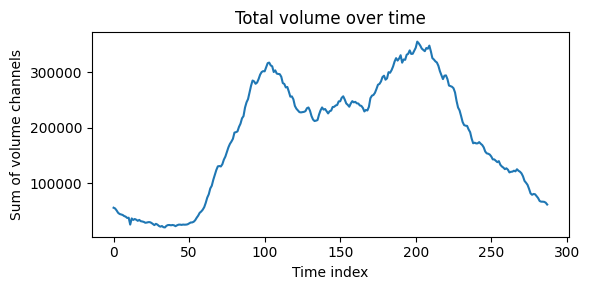

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# X_torch: (T, C, H, W)
# Volume channels are 0, 2, 4, 6

T = X_torch.shape[0]
time_idx = np.arange(T)

# Select only volume channels
volumes = X_torch[:, [0, 2, 4, 6]]  # (T, 4, H, W)

# Sum over volume channels + spatial dims
y_vol = volumes.sum(dim=(1, 2, 3)).cpu().numpy()

plt.figure(figsize=(6, 3))
plt.plot(time_idx, y_vol)
plt.xlabel("Time index")
plt.ylabel("Sum of volume channels")
plt.title("Total volume over time")
plt.tight_layout()
plt.show()


From around 8 am (100) to 5 pm (220) we have the most amount of signals. We are going to focus our study on that ours

This also make the metric more interpretable since we work with less 0s.

**Interpretation of the error with the total volume**

The masked MAE-Focal loss can be interpreted as the average absolute error in predicted probe volume per road cell and 5-minute interval.

To interpret the loss, we compare it against the ground-truth total volume at the corresponding time step.

If we choose hours that have similiar volumes, like we are doing we make this less variable and can roughly compare it with the average volume.

Since a lot of the predictions are trivial in terms of movility, cars staying in the same patch or following the same road we should be carefull with this. Future studies can take this fact to create a more precise metric, but this is not our main focus.


**Range of each channel**

Channel 0: min = 0.00, max = 255.00
Channel 1: min = 0.00, max = 255.00
Channel 2: min = 0.00, max = 255.00
Channel 3: min = 0.00, max = 255.00
Channel 4: min = 0.00, max = 255.00
Channel 5: min = 0.00, max = 255.00
Channel 6: min = 0.00, max = 255.00
Channel 7: min = 0.00, max = 255.00


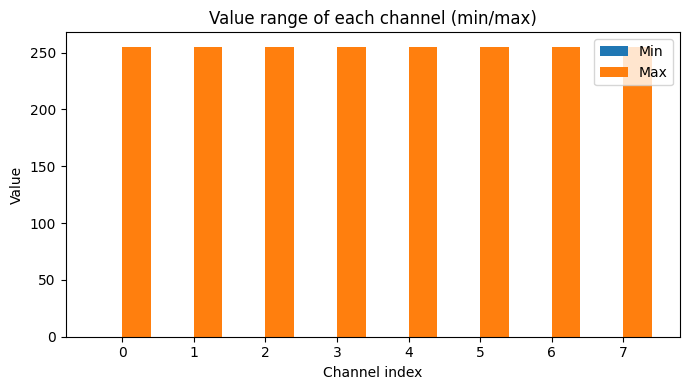

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# X_torch: (T, C, H, W)

C = X_torch.shape[1]
mins = []
maxs = []

for c in range(C):
    vals = X_torch[:, c].cpu().numpy()
    mins.append(vals.min())
    maxs.append(vals.max())

# Print numeric ranges
for c in range(C):
    print(f"Channel {c}: min = {mins[c]:.2f}, max = {maxs[c]:.2f}")

# Bar plot of ranges
plt.figure(figsize=(7,4))
plt.bar(np.arange(C)-0.2, mins, width=0.4, label="Min")
plt.bar(np.arange(C)+0.2, maxs, width=0.4, label="Max")
plt.xlabel("Channel index")
plt.ylabel("Value")
plt.title("Value range of each channel (min/max)")
plt.legend()
plt.tight_layout()
plt.show()


In the HERE / Traffic4Cast datasets, all 8 channels are stored in uint8 format (0–255) by design, because the competition treats the spatio-temporal tensors as “images” for deep learning.

0 ≈ no traffic (no volume, or speed = 0)

255 = clipped maximum

A lo mejor poner aqui toda la explicacion.

The reduction can be seen in data_generation.